In [1]:
# Import core
import pandas as pd
import numpy as np
from numpy import array
import matplotlib.pyplot as plt 
import re
import gc
import string
from IPython.core.interactiveshell import InteractiveShell

# Import custom
from datetime import datetime, timedelta
#from plotnine import *
from pandas.api.types import CategoricalDtype
#from plotnine.data import mpg
#%matplotlib inline

# Import NLTK related
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk import ne_chunk, pos_tag
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.util import ngrams

# Import visualization
import seaborn as sns
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly.offline import iplot
import chart_studio.plotly.plotly as py
import cufflinks

# Import keras
from keras.models import Sequential
from keras import layers
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, Activation, Embedding, LSTM, SpatialDropout1D, Dropout
#from keras.layers.embeddings import Embedding
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping

# Import web-related
from bs4 import BeautifulSoup

# Import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


In [2]:
import psutil
psutil.virtual_memory()

svmem(total=17179869184, available=4971630592, percent=71.1, used=9453203456, free=33591296, active=4934529024, inactive=4911898624, wired=4518674432)

# Definitions

In [ ]:
# Remove digits from location data so we have "City, State" format
def remove_digits(df):
    """Remove digits from location"""
    df["Location_Clean"] = df["Location"].replace(to_replace = r'\d', value='', regex=True).str.rstrip()
    
    return df


# Create a day index which will be used to calcultate when the job was posted
def day_index(df):
    """Create a day index that represents how long ago the job was posted """
    
    df_dummy = pd.DataFrame()
    df_dummy["Day Index"] = df["Date"].str.split(" ", expand=True).get(0)
    df["Day Index"] = df_dummy["Day Index"].apply(lambda x: 0 if (x == 'Just' or x == 'Today') else x)
    
    return df

# Create variables representing the week date range and week index in which the job was posted
def week_posted(df):
    """Create a variable representing the week in which the job was posted"""
    conditions_date = [
        (df['Date Posted'] >= datetime(2020, 3, 4)) & (df['Date Posted'] <= datetime(2020, 3, 7)),
        (df['Date Posted'] >= datetime(2020, 3, 8)) & (df['Date Posted'] <= datetime(2020, 3, 14)),
        (df['Date Posted'] >= datetime(2020, 3, 15)) & (df['Date Posted'] <= datetime(2020, 3, 21)),
        (df['Date Posted'] >= datetime(2020, 3, 22)) & (df['Date Posted'] <= datetime(2020, 3, 28)),
        (df['Date Posted'] >= datetime(2020, 3, 29)) & (df['Date Posted'] <= datetime(2020, 4, 4)),
        (df['Date Posted'] >= datetime(2020, 4, 5)) & (df['Date Posted'] <= datetime(2020, 4, 11)),
        (df['Date Posted'] >= datetime(2020, 4, 12)) & (df['Date Posted'] <= datetime(2020, 4, 18))]
    
    conditions_index = [
        (df['Date Posted'] >= datetime(2020, 3, 4)) & (df['Date Posted'] <= datetime(2020, 3, 7)),
        (df['Date Posted'] >= datetime(2020, 3, 8)) & (df['Date Posted'] <= datetime(2020, 3, 14)),
        (df['Date Posted'] >= datetime(2020, 3, 15)) & (df['Date Posted'] <= datetime(2020, 3, 21)),
        (df['Date Posted'] >= datetime(2020, 3, 22)) & (df['Date Posted'] <= datetime(2020, 3, 28)),
        (df['Date Posted'] >= datetime(2020, 3, 29)) & (df['Date Posted'] <= datetime(2020, 4, 4)),
        (df['Date Posted'] >= datetime(2020, 4, 5)) & (df['Date Posted'] <= datetime(2020, 4, 11)),
        (df['Date Posted'] >= datetime(2020, 4, 12)) & (df['Date Posted'] <= datetime(2020, 4, 18))]
    
    
    
    choices_date = ['Mar 1 - Mar 7','Mar 8 - Mar 14', 'Mar 15 - Mar 21', 'Mar 22 - Mar 28', 'Mar 29 - Apr 4', 'Apr 5 - Apr 11', 'Apr 12 - Apr 18']
    choices_index = [0, 1, 2, 3, 4, 5, 6]

    df['Week Posted'] = np.select(conditions_date, choices_date)
    df['Week Index'] = np.select(conditions_index, choices_index)
    return df


## Import merged dataset

In [ ]:
df_usa = pd.read_csv('df_usa_april_week3_merged_no30days.csv')

df_usa['As of Date'] = pd.to_datetime(df_usa['As of Date'])
df_usa['Date Posted'] = pd.to_datetime(df_usa['Date Posted'])

df_usa.head()
#df_usa.pipe(week_posted).head()

## NLP on Job Description

In [ ]:
### 5 - Description
#sents = sent_tokenize(df1["Description"][1])
#words = word_tokenize(df1["Description"][1])

In [ ]:
def lower_tokens(df):
    """Convert descriptions to lower case and then tokenize them"""
    description_lower = df["Description"].apply(lambda x: x.lower())
    df["Tokens"] = description_lower.apply(lambda x: nltk.word_tokenize(x))    
    return df

def sentence(df):
    description_lower = df["Description"].apply(lambda x: x.lower())
    df["Sentence"] = description_lower.apply(lambda x: sent_tokenize(x))
    return df

In [ ]:
# Takes about Duration: 0:00:59.713260
df_usa.pipe(lower_tokens).head(1)

In [ ]:
# Takes about Duration: 0:00:15
df_usa.pipe(sentence).head(1)

In [ ]:
skills_df = df_usa.filter(items=["Title", "Location", "Company", "Industry", "Sentence", "Description"])
skills_df.head(1)

In [ ]:
skills_df["sent_skills"] = ""

for i in skills_df.index:
    sentence = skills_df["Sentence"][i]
    
    for line in sentence:
        skills = []
        if "skills" in line:
            skills.append(line)
            skills_df["sent_skills"][i] = ' '.join(map(str, skills))
        
skills_df.head(1)

In [ ]:
def lower_tokens(df):
    """Convert descriptions to lower case and then tokenize them"""
    df["Tokens"] = skills_df["sent_skills"].apply(lambda x: nltk.word_tokenize(x))
    
    return df

In [ ]:
skills_df.pipe(lower_tokens).head(1)

In [ ]:
punctuation = string.punctuation 
punctuation

In [ ]:
start_time = datetime.now()

stop_words=set(stopwords.words('english'))

skills_df["Tokens_wo_stop"] = ""

for i in skills_df.index:
    filtered_sent = []
    for w in skills_df["Tokens"][i]:        
        if w not in stop_words:
            filtered_sent.append(w)
            skills_df["Tokens_wo_stop"][i] = filtered_sent
            
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

In [ ]:
def skills_tokens (df):
    total_skills = total_skills + df["Tokens_wo_stop"]
    return total_skills

In [ ]:
statistics=['statistical models','statistical modeling','probability','normal distribution','poisson distribution',
            'survival models','hypothesis testing','bayesian testing','factor analysis','forecasting',
           'markov chain','monte carlo']

machine_learning=['machine learning', 'regression', 'classification', 'clustering', 'logistic', 'K means', 'random forest', 'xgboost', 'svm', 
                 'naive bayes', 'pca', 'decision trees', 'svd', 'ensemble models', 'boltzman machine']

data_engineering=['aws', 'ec2','spark','s3','docker','kubernetes','scala','teradata','google big query',
                  'hive','hadoop','sql']

deep_learning=['neural', 'keras','theano','face detection','convolutional','object detection','yolo','gpu','cuda',
                  'tensorflow','lstm','gan', 'opencv']

r_language=['r', 'ggplot','shiny','cran','dplyr','tidyr','lubridate','knitr']
            
python_language=['python', 'flask','django','pandas','numpy','skitlearn','sklearn','matplotlib',
                'scipy', 'bokeh','statsmodel']

nlp=['nlp', 'lda','lsi','spacy','nltk']
            

# Start the new model from here. Work only with datascience jobs

In [ ]:
df_ds = df_usa.copy()[df_usa["Industry"] == "Datascience"]
df_ds.head(1)

In [ ]:
## Functions

punctuation = '!"#$%\'()*,-:;<=>?@[\\]^_`{|}~'

def sentence(df, target_column):
    description_clean = df[target_column].apply(lambda x: x.replace("\n", " "))
    description_lower = description_clean.apply(lambda x: x.lower())
    description_lower_no_punctuation = description_lower.apply(lambda x: x.translate(str.maketrans('', '', punctuation)))
    df["Sentence"] = description_lower_no_punctuation.apply(lambda x: sent_tokenize(x))
    return df

In [ ]:
df_ds.pipe(sentence(df_ds, "Description")).head(1)

## Chunk each sentence

In [ ]:
tokenized = []
for i in df_ds.index:
    tokenized = tokenized + df_ds.Sentence[i]
    
tokenized[0]

In [ ]:
chunking_list = []
def chunking():
    
    start_time = datetime.now()
        
    try:
        for i in tokenized:
            words = nltk.word_tokenize(i)
            tagged = nltk.pos_tag(words)
            
            chunkGram = r"""Chunk: {<NN.*>+}"""
            
            chunkParser = nltk.RegexpParser(chunkGram)
            chunked = chunkParser.parse(tagged)
            for subtree in chunked.subtrees():
                if subtree.label() == 'Chunk': 
                    chunking_list.append(subtree)
                    #print(subtree)
                    
    except Exception as e:
        print(str(e))

    end_time = datetime.now()
    print('Duration: {}'.format(end_time - start_time))
        
chunking()

In [ ]:
df_chunk = pd.DataFrame(chunking_list)
print(df_chunk.shape)

## Investigate chunk data

In [ ]:
#df_chunk = pd.read_csv("datascience_chunks_may16.csv")
df_chunk.head(1)

In [ ]:
df_chunk_v2 = df_chunk.copy()[df_chunk[5].isna() == True]
df_chunk_v2.shape

In [ ]:
df_chunk_v2 = df_chunk_v2.drop(columns = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16])
df_chunk_v2.head(1)

In [ ]:
def clean_chunk_data(df):
        """Convert df_chunk variables into correct format"""
        df["word_1"] = df[0].apply(lambda x: '' if x is None else x[0])
        df["word_2"] = df[1].apply(lambda x: '' if x is None else x[0])
        df["word_3"] = df[2].apply(lambda x: '' if x is None else x[0])
        df["word_4"] = df[3].apply(lambda x: '' if x is None else x[0])
        df["word_5"] = df[4].apply(lambda x: '' if x is None else x[0])
        #df["word_6"] = df[5].apply(lambda x: '' if x is None else x[0])
        #df["word_7"] = df[6].apply(lambda x: '' if x is None else x[0])
        #df["word_8"] = df[7].apply(lambda x: '' if x is None else x[0])
        #df["word_9"] = df[8].apply(lambda x: '' if x is None else x[0])
        
        df["combined_words"] = df["word_1"] + ' ' + df["word_2"] + ' ' + df["word_3"] + ' ' + df["word_4"] + ' ' + df["word_5"]
        df["combined_words"] = df["combined_words"].str.rstrip()
        return df 

In [ ]:
df_chunk_v2.pipe(clean_chunk_data).head(1)

In [ ]:
df_chunk_no_dups = df_chunk_v2.copy().drop(columns = [0, 1, 2, 3, 4]).drop_duplicates()

print(df_chunk_no_dups.shape)

In [ ]:
df_chunk_training_1000 = df_chunk_no_dups.copy().sample(n = 1000) 
df_chunk_training_1000.shape

In [ ]:
df_chunk_training_1000[:5]

In [ ]:
#df_chunk_training_1000.to_csv("df_chunk_unique_part2_may16.csv")

## Import all data science chunks

In [3]:
#df_chunk = pd.read_csv("datascience_chunks_may16.csv")

df_tagged_chunk_0_to_1000 = pd.read_csv("df_chunk_unique_may16_tagged.csv", usecols = ["combined_words", "Technical", "Soft"])
df_tagged_chunk_1001_to_2000 = pd.read_csv("df_chunk_unique_part2_may16_tagged.csv", usecols = ["combined_words", "Technical", "Soft"])
df_tagged_chunk = df_tagged_chunk_0_to_1000.append(df_tagged_chunk_1001_to_2000).reset_index().drop(columns = ('index'))

df_tagged_chunk.head(1)

,combined_words,Technical,Soft
0,business cases experience,0,1


In [4]:
df_chunk_tech_1 = df_tagged_chunk[df_tagged_chunk["Technical"] == 1]
df_chunk_tech_0 = df_tagged_chunk[df_tagged_chunk["Technical"] == 0].sample(n=598, random_state=1)

df_chunk_tech = df_chunk_tech_1.append(df_chunk_tech_0).sample(frac = 1).reset_index(drop = True)
df_chunk_tech.head(1)

,combined_words,Technical,Soft
0,sentiment,1,0


In [5]:
df_chunk_tech.shape

(1196, 3)

# Word embeddings model

In [6]:
X_train_tech, X_test_tech, y_train_tech, y_test_tech = train_test_split(df_chunk_tech["combined_words"], df_chunk_tech["Technical"], test_size=0.1, random_state=42)
X_train_tech.shape
X_test_tech.shape
X_train_tech[:2]

943    boston massachusetts
906                  forces
Name: combined_words, dtype: object

In [102]:
#vocab_size = 2000
encoded_docs_train_tech = [one_hot(d, vocab_size) for d in X_train_tech]
encoded_docs_train_tech[0:2]

[[1235, 839], [909]]

In [103]:
# pad documents to a max length of 4 words
max_length = 5
padded_docs_train_tech = pad_sequences(encoded_docs_train_tech, maxlen=max_length, padding='post')
print(padded_docs_train_tech[:5])

[[1235  839    0    0    0]
 [ 909    0    0    0    0]
 [ 668 1236    0    0    0]
 [ 334  574    0    0    0]
 [1032 1027    0    0    0]]


In [104]:
encoded_docs_test_tech = [one_hot(d, vocab_size) for d in X_test_tech]

padded_docs_test_tech = pad_sequences(encoded_docs_test_tech, maxlen=max_length, padding='post')
print(padded_docs_test_tech[:5])

[[ 738  500 1023    0    0]
 [1355    0    0    0    0]
 [1304  527   13    0    0]
 [1381    0    0    0    0]
 [ 970  970  339 1175   33]]


In [105]:
padded_docs_train_tech_df = pd.DataFrame(data=padded_docs_train_tech[0:,0:],    # values
             index=range(0,len(padded_docs_train_tech)),    # 1st column as index
             columns=range(1,6))

padded_docs_test_tech_df = pd.DataFrame(data=padded_docs_test_tech[0:,0:],    # values
             index=range(0,len(padded_docs_test_tech)),    # 1st column as index
             columns=range(1,6))

padded_docs_train_tech_df['combined_words'] = 'test'
padded_docs_train_tech_df['original_index'] = 0
padded_docs_test_tech_df['combined_words'] = 'test'
padded_docs_test_tech_df['original_index'] = 0

In [106]:
X_train_tech_df = pd.DataFrame(data=X_train_tech)
X_train_tech_df['new_index']=range(0,len(X_train_tech_df.index))
X_train_tech_df['original_index']=X_train_tech_df.index
X_train_tech_df = X_train_tech_df.set_index('new_index')
X_train_tech_df.reset_index
X_train_tech_df.index.names = ['index']

X_test_tech_df = pd.DataFrame(data=X_test_tech)
X_test_tech_df['new_index']=range(0,len(X_test_tech_df.index))
X_test_tech_df['original_index']=X_test_tech_df.index
X_test_tech_df = X_test_tech_df.set_index('new_index')
X_test_tech_df.reset_index
X_test_tech_df.index.names = ['index']

In [107]:
for i in range(0, len(X_train_tech_df)-1):
    padded_docs_train_tech_df['combined_words'][i] = X_train_tech_df['combined_words'][i]
    padded_docs_train_tech_df['original_index'][i] = X_train_tech_df['original_index'][i]

for i in range(0, len(X_test_tech_df)-1):
    padded_docs_test_tech_df['combined_words'][i] = X_test_tech_df['combined_words'][i]
    padded_docs_test_tech_df['original_index'][i] = X_test_tech_df['original_index'][i]

In [108]:
X_train_tech.head(3)

943    boston massachusetts
906                  forces
451    image classification
Name: combined_words, dtype: object

In [109]:
df_chunk_tech[df_chunk_tech['combined_words']=='boston massachusetts']

,combined_words,Technical,Soft
943,boston massachusetts,0,0
1033,boston massachusetts,0,0


In [110]:
padded_docs_train_tech_df[padded_docs_train_tech_df[1]==1128]

,1,2,3,4,5,combined_words,original_index


In [111]:
X_train_tech[574]

'agriscienceâ„¢'

In [112]:
X_train_tech[0]

'sentiment'

In [113]:
padded_docs_train_tech_df.head()

,1,2,3,4,5,combined_words,original_index
0,1235,839,0,0,0,boston massachusetts,943
1,909,0,0,0,0,forces,906
2,668,1236,0,0,0,image classification,451
3,334,574,0,0,0,applications tools,260
4,1032,1027,0,0,0,constraints experience,244


In [114]:
padded_docs_test_tech_df.head()

,1,2,3,4,5,combined_words,original_index
0,738,500,1023,0,0,support application integration,636
1,1355,0,0,0,0,confidentiality,243
2,1304,527,13,0,0,product design enhancements,1013
3,1381,0,0,0,0,adplatform,1113
4,970,970,339,1175,33,java c/c++ r javascript/node,58


In [115]:
for i in range (1,5):

    print(padded_docs_train_tech_df[i].value_counts())

317     89
256     24
1097    14
302     11
1027    11
527     10
268      9
831      9
1304     8
900      8
417      8
339      8
1331     8
1247     7
648      7
655      7
207      6
325      6
905      6
603      6
292      6
584      6
1014     5
359      5
1093     5
1252     5
1166     5
988      5
787      5
492      5
        ..
1015     1
1022     1
1023     1
934      1
933      1
931      1
889      1
844      1
847      1
849      1
858      1
859      1
863      1
869      1
876      1
877      1
878      1
891      1
925      1
893      1
902      1
912      1
914      1
916      1
917      1
918      1
920      1
922      1
923      1
3        1
Name: 1, Length: 536, dtype: int64
0       169
317      53
829      14
1097     12
302      12
527      12
912      12
1027     10
502       9
831       8
268       8
1304      8
985       7
292       7
574       7
262       7
888       7
1262      6
390       6
850       6
903       6
207       6
582       6
1057      5
1277  

In [97]:
vocab_size = 0

for i in range (1,5):
    vocab_size+= padded_docs_train_tech_df[i].nunique()
    
vocab_size

1435

In [116]:
for i in range (1,5):

    print(padded_docs_train_tech_df[i].max())

    print(padded_docs_train_tech_df[i].nunique())

    print(padded_docs_train_tech_df[i].unique())

1433
536
[1235  909  668  334 1032 1251 1027  895  268  600  197  536  301  738
  317  506  302  554 1378  858  406  179 1252  115  216 1415  342  954
 1282 1326  210  953  219  785 1182  162 1097  256  912  965 1246   31
  339  918  107  231  946  679  784  930 1070  779 1281 1049 1343   45
 1279 1237  417  500 1091  470 1302  524  141   53  603  445  749  538
  359  215  407   95  309  360  632  502  815  767 1215  414  303  280
 1355  900 1079  887  548  717  393  884 1245 1405  914 1166 1397 1093
  970  962 1146  694  869  995  325  905  597  148  527  213  517  988
  802  348  370  902  866  838  655  329  587  983 1331  686  831  923
  224 1356 1105  567 1433  980   67  421  483  917  574 1304  939   72
   16 1204 1019 1377  787 1374  541  853 1014 1099  672 1074 1262  484
  707  822  104 1332 1400  903  684 1135  354  307  292  237  511 1381
 1269 1425  130 1191 1298 1212  829  193 1297  262 1127  611  825  828
  950 1301  582  537  245 1104  390  448  949  969  638 1317  495  2

In [117]:
# define the model
embeddings_model = Sequential()
embeddings_model.add(Embedding(vocab_size, 2, input_length=max_length))
embeddings_model.add(Flatten())
embeddings_model.add(Dense(1, activation='sigmoid'))

In [118]:
# compile the model
embeddings_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# summarize the model
print(embeddings_model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 5, 2)              2870      
_________________________________________________________________
flatten_3 (Flatten)          (None, 10)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 2,881
Trainable params: 2,881
Non-trainable params: 0
_________________________________________________________________
None


In [119]:
# fit the model
embeddings_model.fit(padded_docs_train_tech, y_train_tech, epochs=20, verbose=0)

/Users/pavel/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning:

Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.

/Users/pavel/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning:

Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.



In [120]:
model_tech = embeddings_model.fit(padded_docs_train_tech, y_train_tech, epochs=25, validation_data = (padded_docs_test_tech, y_test_tech), verbose=2)

Train on 1076 samples, validate on 120 samples
Epoch 1/25
 - 0s - loss: 0.5065 - accuracy: 0.8448 - val_loss: 0.6836 - val_accuracy: 0.6167
Epoch 2/25
 - 0s - loss: 0.4956 - accuracy: 0.8476 - val_loss: 0.6858 - val_accuracy: 0.6083
Epoch 3/25
 - 0s - loss: 0.4850 - accuracy: 0.8513 - val_loss: 0.6880 - val_accuracy: 0.6000
Epoch 4/25
 - 0s - loss: 0.4745 - accuracy: 0.8541 - val_loss: 0.6907 - val_accuracy: 0.6000
Epoch 5/25
 - 0s - loss: 0.4644 - accuracy: 0.8550 - val_loss: 0.6946 - val_accuracy: 0.6000
Epoch 6/25
 - 0s - loss: 0.4547 - accuracy: 0.8625 - val_loss: 0.6976 - val_accuracy: 0.6000
Epoch 7/25
 - 0s - loss: 0.4452 - accuracy: 0.8643 - val_loss: 0.7014 - val_accuracy: 0.5917
Epoch 8/25
 - 0s - loss: 0.4359 - accuracy: 0.8690 - val_loss: 0.7054 - val_accuracy: 0.6000
Epoch 9/25
 - 0s - loss: 0.4274 - accuracy: 0.8680 - val_loss: 0.7101 - val_accuracy: 0.5917
Epoch 10/25
 - 0s - loss: 0.4187 - accuracy: 0.8717 - val_loss: 0.7149 - val_accuracy: 0.5833
Epoch 11/25
 - 0s - lo

In [121]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

Training Accuracy: 0.9517
Testing Accuracy:  0.5583


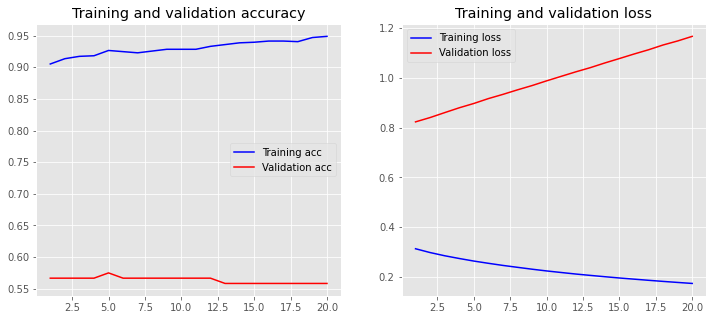

In [122]:
test_sample = "analytical skills"

history = embeddings_model.fit(padded_docs_train_tech, y_train_tech,
                    epochs=20,
                    verbose=False,
                    validation_data=(padded_docs_test_tech, y_test_tech),
                    batch_size=10)

loss, accuracy = embeddings_model.evaluate(padded_docs_train_tech, y_train_tech, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = embeddings_model.evaluate(padded_docs_test_tech, y_test_tech, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [ ]:
#model.save('CNN_test_may18_10pct.model')

## Test model prediction

In [ ]:
prediction_tech = embeddings_model.predict(padded_docs_test_tech)

In [ ]:
df_tech= pd.DataFrame(X_test_tech)
df_tech["skill_tech"] = y_test_tech
df_tech["prediction"] = prediction_tech.round(0)
df_tech.shape

In [ ]:
df_tech.head(5)

In [ ]:
actual_values = df_tech.skill_tech.values
predicted_values = df_tech.prediction.values.astype(int)

predicted_values

In [ ]:
confusion = confusion_matrix(actual_values, predicted_values)
print(confusion)

## Second version of model: 80 vs 20 split

In [ ]:
X_train_tech, X_test_tech, y_train_tech, y_test_tech = train_test_split(df_chunk_tech["combined_words"], df_chunk_tech["Technical"], test_size=0.2, random_state=42)
X_train_tech.shape

vocab_size = 2000
encoded_docs_train_tech = [one_hot(d, vocab_size) for d in X_train_tech]

# pad documents to a max length of 4 words
max_length = 5
padded_docs_train_tech = pad_sequences(encoded_docs_train_tech, maxlen=max_length, padding='post')
print(padded_docs_train_tech)

encoded_docs_test_tech = [one_hot(d, vocab_size) for d in X_test_tech]

padded_docs_test_tech = pad_sequences(encoded_docs_test_tech, maxlen=max_length, padding='post')
#print(padded_docs_test)

# define the model
model = Sequential()
model.add(Embedding(vocab_size, 5, input_length=max_length))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# summarize the model
print(model.summary())

# fit the model
model.fit(padded_docs_train_tech, y_train_tech, epochs=20, verbose=0)

model_tech_v2 = model.fit(padded_docs_train_tech, y_train_tech, epochs=25, 
                          validation_data = (padded_docs_test_tech, y_test_tech), verbose=2)

#model.save('CNN_test_may18_12pct.model')

prediction_tech_v2 = model.predict(padded_docs_test_tech)

df_tech_v2= pd.DataFrame(X_test_tech)
df_tech_v2["skill_tech"] = y_test_tech
df_tech_v2["prediction"] = prediction_tech_v2.round(0)
df_tech_v2.shape

actual_values_v2 = df_tech_v2.skill_tech.values
predicted_values_v2 = df_tech_v2.prediction.values.astype(int)

confusion_v2 = confusion_matrix(actual_values_v2, predicted_values_v2)
print(confusion_v2)

# Embeddings Layer parameter changes (Real Python website test)

In [ ]:
embedding_dim = 50
maxlen = 5


embeddings_model_v1 = Sequential()
embeddings_model_v1.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
embeddings_model_v1.add(layers.Flatten())
embeddings_model_v1.add(layers.Dense(10, activation='relu'))
embeddings_model_v1.add(layers.Dense(1, activation='sigmoid'))
embeddings_model_v1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
embeddings_model_v1.summary()

In [ ]:
history = embeddings_model_v1.fit(padded_docs_train_tech, y_train_tech,
                    epochs=20,
                    verbose=False,
                    validation_data=(padded_docs_test_tech, y_test_tech),
                    batch_size=10)

In [ ]:
loss, accuracy = embeddings_model_v1.evaluate(padded_docs_train_tech, y_train_tech, verbose=False)
print("train_teching Accuracy: {:.4f}".format(accuracy))
loss, accuracy = embeddings_model_v1.evaluate(padded_docs_test_tech, y_test_tech, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

# Real Python website test version 2 model

In [ ]:
embeddings_model_v2 = Sequential()
embeddings_model_v2.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
embeddings_model_v2.add(layers.GlobalMaxPool1D())
embeddings_model_v2.add(layers.Dense(10, activation='relu'))
embeddings_model_v2.add(layers.Dense(1, activation='sigmoid'))
embeddings_model_v2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
embeddings_model_v2.summary()

In [ ]:
history_v2 = embeddings_model_v2.fit(padded_docs_train_tech, y_train_tech,
                    epochs=20,
                    verbose=False,
                    validation_data=(padded_docs_test_tech, y_test_tech),
                    batch_size=10)

In [ ]:
loss, accuracy = embeddings_model_v2.evaluate(padded_docs_train_tech, y_train_tech, verbose=False)
print("train_teching Accuracy: {:.4f}".format(accuracy))
loss, accuracy = embeddings_model_v2.evaluate(padded_docs_test_tech, y_test_tech, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history_v2)

In [ ]:
prediction_tech_v2 = embeddings_model_v2.predict(padded_docs_test_tech)

df_tech_v2= pd.DataFrame(X_test_tech)
df_tech_v2["skill_tech"] = y_test_tech
df_tech_v2["prediction"] = prediction_tech_v2.round(0)

actual_values_v2 = df_tech_v2.skill_tech.values
predicted_values_v2 = df_tech_v2.prediction.values.astype(int)

confusion_v2 = confusion_matrix(actual_values_v2, predicted_values_v2)
print(confusion_v2)

## Real python test v3

In [ ]:
embedding_dim = 5

embeddings_model_v3 = Sequential()
embeddings_model_v3.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
embeddings_model_v3.add(layers.Conv1D(128, 5, activation='relu'))
embeddings_model_v3.add(layers.GlobalMaxPooling1D())
embeddings_model_v3.add(layers.Dense(10, activation='relu'))
embeddings_model_v3.add(layers.Dense(1, activation='sigmoid'))
embeddings_model_v3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
embeddings_model_v3.summary()

In [ ]:
history_v3 = embeddings_model_v3.fit(padded_docs_train_tech, y_train_tech,
                    epochs=20,
                    verbose=False,
                    validation_data=(padded_docs_test_tech, y_test_tech),
                    batch_size=10)

In [ ]:
loss, accuracy = embeddings_model_v3.evaluate(padded_docs_train_tech, y_train_tech, verbose=False)
print("train_teching Accuracy: {:.4f}".format(accuracy))
loss, accuracy = embeddings_model_v3.evaluate(padded_docs_test_tech, y_test_tech, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history_v3)

In [ ]:
prediction_tech_v3 = embeddings_model_v3.predict(padded_docs_test_tech)

df_tech_v3= pd.DataFrame(X_test_tech)
df_tech_v3["skill_tech"] = y_test_tech
df_tech_v3["prediction"] = prediction_tech_v3.round(0)

actual_values_v3 = df_tech_v3.skill_tech.values
predicted_values_v3 = df_tech_v3.prediction.values.astype(int)

confusion_v3 = confusion_matrix(actual_values_v3, predicted_values_v3)
print(confusion_v3)

# Get Embedding Model weights

In [36]:
def extract_weights(name, model):
    """Extract weights from a neural network model"""
    
    # Extract weights
    weight_layer = model.get_layer(name)
    weights = weight_layer.get_weights()[0]
    
    # Normalize
    weights = weights / np.linalg.norm(weights, axis = 1).reshape((-1, 1))
    return weights

In [37]:
for layer in embeddings_model.layers:
    print(layer.name)

embedding_1
flatten_1
dense_1


In [123]:
embeddings_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 5, 2)              2870      
_________________________________________________________________
flatten_3 (Flatten)          (None, 10)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 2,881
Trainable params: 2,881
Non-trainable params: 0
_________________________________________________________________


In [134]:
weights_class = extract_weights('embedding_3', embeddings_model)
weights_class[:5]

array([[ 0.99574304, -0.09217263],
       [-0.86626744,  0.49958047],
       [ 0.35533863, -0.9347376 ],
       [-0.7184594 ,  0.6955689 ],
       [-0.97427684,  0.22535451]], dtype=float32)

In [138]:
pd.DataFrame(data=weights_class)[0].nunique()

1435

In [127]:
embeddings_model.get_layer('embedding_3').output

<tf.Tensor 'embedding_3/embedding_lookup/Identity_1:0' shape=(None, 5, 2) dtype=float32>

In [ ]:
# Possibly useful function to create a model from an intermediate layer

#from keras.models import Model

#model = ...  # include here your original model

#layer_name = 'my_layer'
#intermediate_layer_model = Model(inputs=model.input,
#                                 outputs=model.get_layer(layer_name).output)
#intermediate_output = intermediate_layer_model.predict(data)

In [128]:
padded_docs_train_tech_df['weights'] = ''
padded_docs_test_tech_df['weights'] = ''

i=0
for d in weights_class:
    padded_docs_train_tech_df['weights'][i] = d
    i+=1
    
i=0
for d in weights_class:
    padded_docs_test_tech_df['weights'][i] = d
    i+=1
    
padded_docs_train_tech_df.head()

,1,2,3,4,5,combined_words,original_index,weights
0,1235,839,0,0,0,boston massachusetts,943,"[0.99574304, -0.09217263]"
1,909,0,0,0,0,forces,906,"[-0.86626744, 0.49958047]"
2,668,1236,0,0,0,image classification,451,"[0.35533863, -0.9347376]"
3,334,574,0,0,0,applications tools,260,"[-0.7184594, 0.6955689]"
4,1032,1027,0,0,0,constraints experience,244,"[-0.97427684, 0.22535451]"


In [129]:
padded_docs_test_tech_df.head()

,1,2,3,4,5,combined_words,original_index,weights
0,738,500,1023,0,0,support application integration,636,"[0.99574304, -0.09217263]"
1,1355,0,0,0,0,confidentiality,243,"[-0.86626744, 0.49958047]"
2,1304,527,13,0,0,product design enhancements,1013,"[0.35533863, -0.9347376]"
3,1381,0,0,0,0,adplatform,1113,"[-0.7184594, 0.6955689]"
4,970,970,339,1175,33,java c/c++ r javascript/node,58,"[-0.97427684, 0.22535451]"


# Visualization

In [57]:
from sklearn.manifold import TSNE
#from umap import UMAP

In [58]:
def reduce_dim(weights, components = 3, method = 'tsne'):
    """Reduce dimensions of embeddings"""
    if method == 'tsne':
        return TSNE(components, metric = 'cosine').fit_transform(weights)
    elif method == 'umap':
        # Might want to try different parameters for UMAP
        return UMAP(n_components=components, metric = 'cosine', 
                    init = 'random', n_neighbors = 5).fit_transform(weights)

In [130]:
# Reduce dimensions from 10 down to 2 using TSNE method
combined_words_r = reduce_dim(weights_class, components = 2, method = 'tsne')
combined_words_r.shape

(1435, 2)

In [82]:
combined_words_r[0:5]

array([[-35.93049   ,   0.18120028],
       [-12.980926  ,  15.723465  ],
       [ 40.121178  ,   3.730411  ],
       [-37.7432    ,  14.671775  ],
       [-47.95029   , -16.949986  ]], dtype=float32)

In [131]:
padded_docs_train_tech_df['tsne1'] = 0.0
padded_docs_train_tech_df['tsne2'] = 0.0
padded_docs_test_tech_df['tsne1'] = 0.0
padded_docs_test_tech_df['tsne2'] = 0.0

i=0
for d, e in combined_words_r:
    padded_docs_train_tech_df['tsne1'][i] = d
    padded_docs_train_tech_df['tsne2'][i] = e
    i+=1
    
i=0
for d, e in combined_words_r:
    padded_docs_test_tech_df['tsne1'][i] = d
    padded_docs_test_tech_df['tsne2'][i] = e
    i+=1
    
padded_docs_train_tech_df.head()

,1,2,3,4,5,combined_words,original_index,weights,tsne1,tsne2
0,1235,839,0,0,0,boston massachusetts,943,"[0.99574304, -0.09217263]",24.766762,4.052248
1,909,0,0,0,0,forces,906,"[-0.86626744, 0.49958047]",18.555532,41.824707
2,668,1236,0,0,0,image classification,451,"[0.35533863, -0.9347376]",-31.568941,-4.037198
3,334,574,0,0,0,applications tools,260,"[-0.7184594, 0.6955689]",32.738224,31.284283
4,1032,1027,0,0,0,constraints experience,244,"[-0.97427684, 0.22535451]",6.676236,44.156738


In [132]:
padded_docs_train_tech_df[padded_docs_train_tech_df['original_index']==1160]

,1,2,3,4,5,combined_words,original_index,weights,tsne1,tsne2
14,317,219,938,413,0,data visualization report automation,1160,"[0.9097997, 0.4150476]",30.950512,-7.9658


In [133]:
padded_docs_train_tech_df[padded_docs_train_tech_df['original_index']==979]

,1,2,3,4,5,combined_words,original_index,weights,tsne1,tsne2
15,317,912,1187,0,0,data management initiative,979,"[0.66212493, -0.7493934]",-3.717495,-10.073831


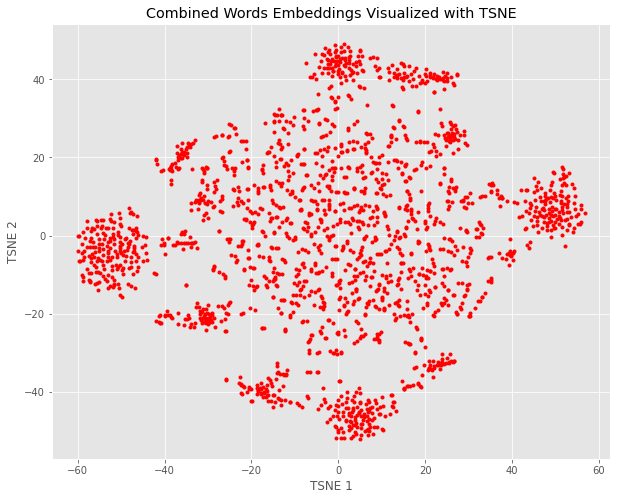

In [62]:
InteractiveShell.ast_node_interactivity = 'last'

plt.figure(figsize = (10, 8))
plt.plot(combined_words_r[:, 0], combined_words_r[:, 1], 'r.')
plt.xlabel('TSNE 1'); plt.ylabel('TSNE 2'); plt.title('Combined Words Embeddings Visualized with TSNE');

In [63]:
import random

padded_docs_train_tech_df_rand = padded_docs_train_tech_df.iloc[
    random.sample(range(0, len(padded_docs_train_tech_df.index)-1), 100)]
padded_docs_train_tech_df_rand = padded_docs_train_tech_df_rand.reset_index().drop(columns = ('index'))
padded_docs_train_tech_df_rand.head()

,1,2,3,4,5,combined_words,original_index,tsne1,tsne2
0,431,887,0,0,0,evaluation results,46,18.362757,-1.975880
1,1621,1503,0,0,0,knowledge research,284,-0.511884,44.025364
2,564,1128,1101,1094,709,deliverables data analysis prepare reports,832,48.832333,11.574444
3,1511,1321,0,0,0,core concepts,1043,9.042949,13.699334
4,1844,1444,0,0,0,web applications,446,-3.455083,14.737556


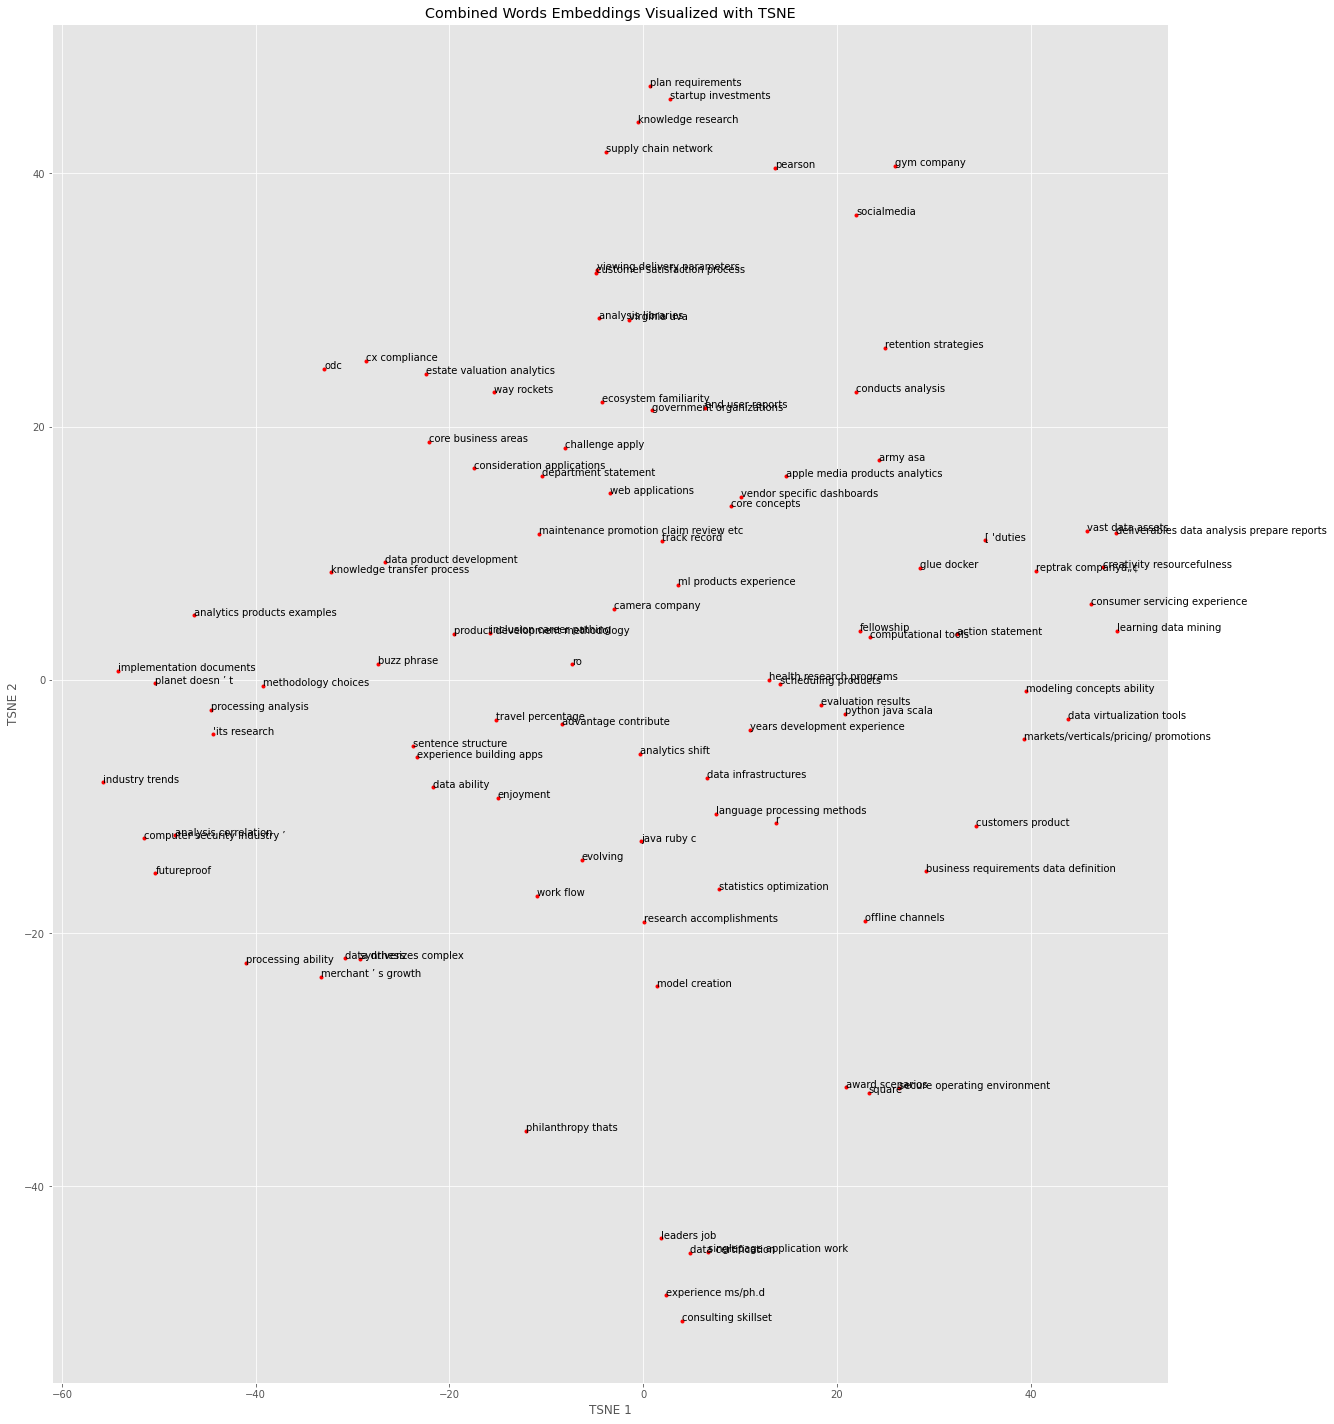

In [64]:
InteractiveShell.ast_node_interactivity = 'last'

plt.figure(figsize = (20, 25))
plt.plot(padded_docs_train_tech_df_rand['tsne1'], padded_docs_train_tech_df_rand['tsne2'], 'r.')

for i, txt in enumerate(padded_docs_train_tech_df_rand['combined_words']):
    plt.annotate(txt, (padded_docs_train_tech_df_rand['tsne1'][i], padded_docs_train_tech_df_rand['tsne2'][i]))
    
plt.xlabel('TSNE 1'); plt.ylabel('TSNE 2'); plt.title('Combined Words Embeddings Visualized with TSNE');

plt.savefig('Embeddings_sample.png')

## LSTM Test

In [ ]:
STOPWORDS = set(stopwords.words('english'))

InteractiveShell.ast_node_interactivity = 'all'

cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

In [ ]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 2000

MAX_SEQUENCE_LENGTH = 5

# This is the size of the vector space in which words will be embedded. 
# It defines the size of the output vectors from this layer for each word. 
EMBEDDING_DIM = 5

# This is the length of input sequences. 
#For example, if all of your input documents are comprised of 1000 words, this would be 1000.
INPUT_LENGTH = 5

max_len = 1

In [ ]:
lstm_model = Sequential()
lstm_model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=5, dropout=0.2))
lstm_model.add(SpatialDropout1D(0.2))

lstm_model.add(LSTM(100, recurrent_dropout=0.2, dropout=0.2))
lstm_model.add(Dense(max_len))
lstm_model.add(Activation('relu'))

lstm_model.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])

lstm_model.summary()

In [ ]:
history = lstm_model.fit(padded_docs_train_tech, y_train_tech, epochs=10, batch_size=5 ,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

In [ ]:
lstm_predict_tech = lstm_model.predict(padded_docs_test_tech)

df_lstm_tech= pd.DataFrame(X_test_tech)
df_lstm_tech["skill_tech"] = y_test_tech
df_lstm_tech["prediction"] = lstm_predict_tech.round(0)

lstm_actual = df_lstm_tech.skill_tech.values
lstm_predict_tech = df_lstm_tech.prediction.values.astype(int)

lstm_confusion = confusion_matrix(lstm_actual, lstm_predict_tech)
print(lstm_confusion)

In [ ]:
df_lstm_tech["prediction_rounded"] = lstm_predict_tech.round(2)

In [ ]:
df_lstm_tech.head(5)

In [ ]:
df_lstm_tech["prediction_adj"] = df_lstm_tech["prediction_rounded"].apply(lambda x: 0 if x <= .4 else 1 )
df_lstm_tech.head(1)

In [ ]:
score,acc = lstm_model.evaluate(padded_docs_test_tech, y_test_tech, verbose = 2, batch_size = 5)

print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

In [ ]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

In [ ]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

### Lenght of chunks 

In [ ]:
test = pd.DataFrame(X_train_tech.reset_index(drop = True))
test['word_count'] = test['combined_words'].apply(lambda x: len(word_tokenize(x)))
test[:5]

In [ ]:
test.word_count.median()

In [ ]:
test.word_count.mean()

## Soft skills version: 20 vs 80 split


In [ ]:
X_train_soft, X_test_soft, y_train_soft, y_test_soft = train_test_split(df_chunk["combined_words"], df_chunk["Soft"], test_size=0.2, random_state=42)
X_train_soft.shape

vocab_size = 250000
encoded_docs_train_soft = [one_hot(d, vocab_size) for d in X_train_soft]

# pad documents to a max length of 4 words
max_length = 5
padded_docs_train_soft = pad_sequences(encoded_docs_train_soft, maxlen=max_length, padding='post')
print(padded_docs_train_soft)

encoded_docs_test_soft = [one_hot(d, vocab_size) for d in X_test_soft]

padded_docs_test_soft = pad_sequences(encoded_docs_test_soft, maxlen=max_length, padding='post')
#print(padded_docs_test)

# define the model
model = Sequential()
model.add(Embedding(vocab_size, 10, input_length=max_length))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# summarize the model
print(model.summary())

# fit the model
model.fit(padded_docs_train_soft, y_train_soft, epochs=20, verbose=0)

model_soft = model.fit(padded_docs_train_soft, y_train_soft, epochs=25, validation_data = (padded_docs_test_soft, y_test_soft), verbose=2)

#model.save('CNN_soft_may18_10pct.model')

prediction_soft = model.predict(padded_docs_test_soft)

df_soft= pd.DataFrame(X_test_soft)
df_soft["skill_soft"] = y_test_soft
df_soft["prediction"] = prediction_soft.round(0)
df_soft.shape

actual_values = df_soft.skill_soft.values
predicted_values = df_soft.prediction.values.astype(int)

confusion = confusion_matrix(actual_values, predicted_values)
print(confusion)

# Test full dataset

In [ ]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 250000

MAX_SEQUENCE_LENGTH = 5

# This is the size of the vector space in which words will be embedded. 
# It defines the size of the output vectors from this layer for each word. 
EMBEDDING_DIM = 5

# This is the length of input sequences. 
#For example, if all of your input documents are comprised of 1000 words, this would be 1000.
INPUT_LENGTH = 5

#max_len = 1

lstm_model = Sequential()
lstm_model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=5, dropout=0.2))
lstm_model.add(SpatialDropout1D(0.2))

lstm_model.add(LSTM(100, recurrent_dropout=0.2, dropout=0.2))
lstm_model.add(Dense(max_len))
lstm_model.add(Activation('relu'))

lstm_model.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])

lstm_model.summary()

In [ ]:
vocab_size = 250000
encoded_docs_train = [one_hot(d, vocab_size) for d in df_chunk_df_no_dups["combined_words"]]

In [ ]:
# pad documents to a max length of 4 words
max_length = 5
padded_docs_train = pad_sequences(encoded_docs_train, maxlen=max_length, padding='post')
print(padded_docs_train)

In [ ]:
prediction_full = lstm_model.predict(padded_docs_train)
prediction_full.shape

In [ ]:
df_chunk_no_dups["prediction"] = prediction_full.round(2)
df_chunk_no_dups[:5]

In [ ]:
df_skill_predict = df_chunk_no_dups[df_chunk_no_dups["prediction"] >= .8]
df_noskill_predict = df_chunk_no_dups[df_chunk_no_dups["prediction"] <= .2]

In [ ]:
df_skill_predict[:10]

In [ ]:
df_predict = pd.DataFrame(df_skill_predict.groupby(["combined_words", "prediction"]).count()["word_1"].sort_values(ascending = False)).reset_index().rename(columns = {'word_1' : "count"})

df_predict[:10]
